BƯỚC 6: REFINEMENT - FINE-TUNING & MULTIPLE SIMULATION RUNS

📂 6.1: Phân tích validation metrics từ Bước 5...
✅ Loaded Bước 5 outputs

📊 Previous validation metrics:
   • Chi-square p-value: 0.0000
   • KS test p-value: 0.0000
   • Wasserstein distance: 0.6176

🎯 Validation assessment:
   • Event distribution: ⚠️ NEEDS ADJUSTMENT
   • Grade distribution: ⚠️ NEEDS ADJUSTMENT
   • Wasserstein distance: ✅ PASS

⚠️ Simulation cần fine-tuning!

6.2: PHÂN TÍCH CHI TIẾT CÁC DISTRIBUTIONS

📊 Synthetic Grades Distribution Analysis:
   • Mean: 6.917
   • Std: 1.460
   • Skewness: -0.013
   • Kurtosis: -0.332
   • Normality test p-value: 0.0000
     → ⚠️ Not normal (consider transformations)
   • Best fitting distribution: norm (KS=0.0173)

📊 Knowledge Levels Distribution Analysis:
   • Mean: 0.522
   • Std: 0.138
   • Skewness: 0.491
   • Kurtosis: -0.281
   • Normality test p-value: 0.0000
     → ⚠️ Not normal (consider transformations)
   • Best fitting distribution: gamma (KS=0.0314)

6.3: XÁ

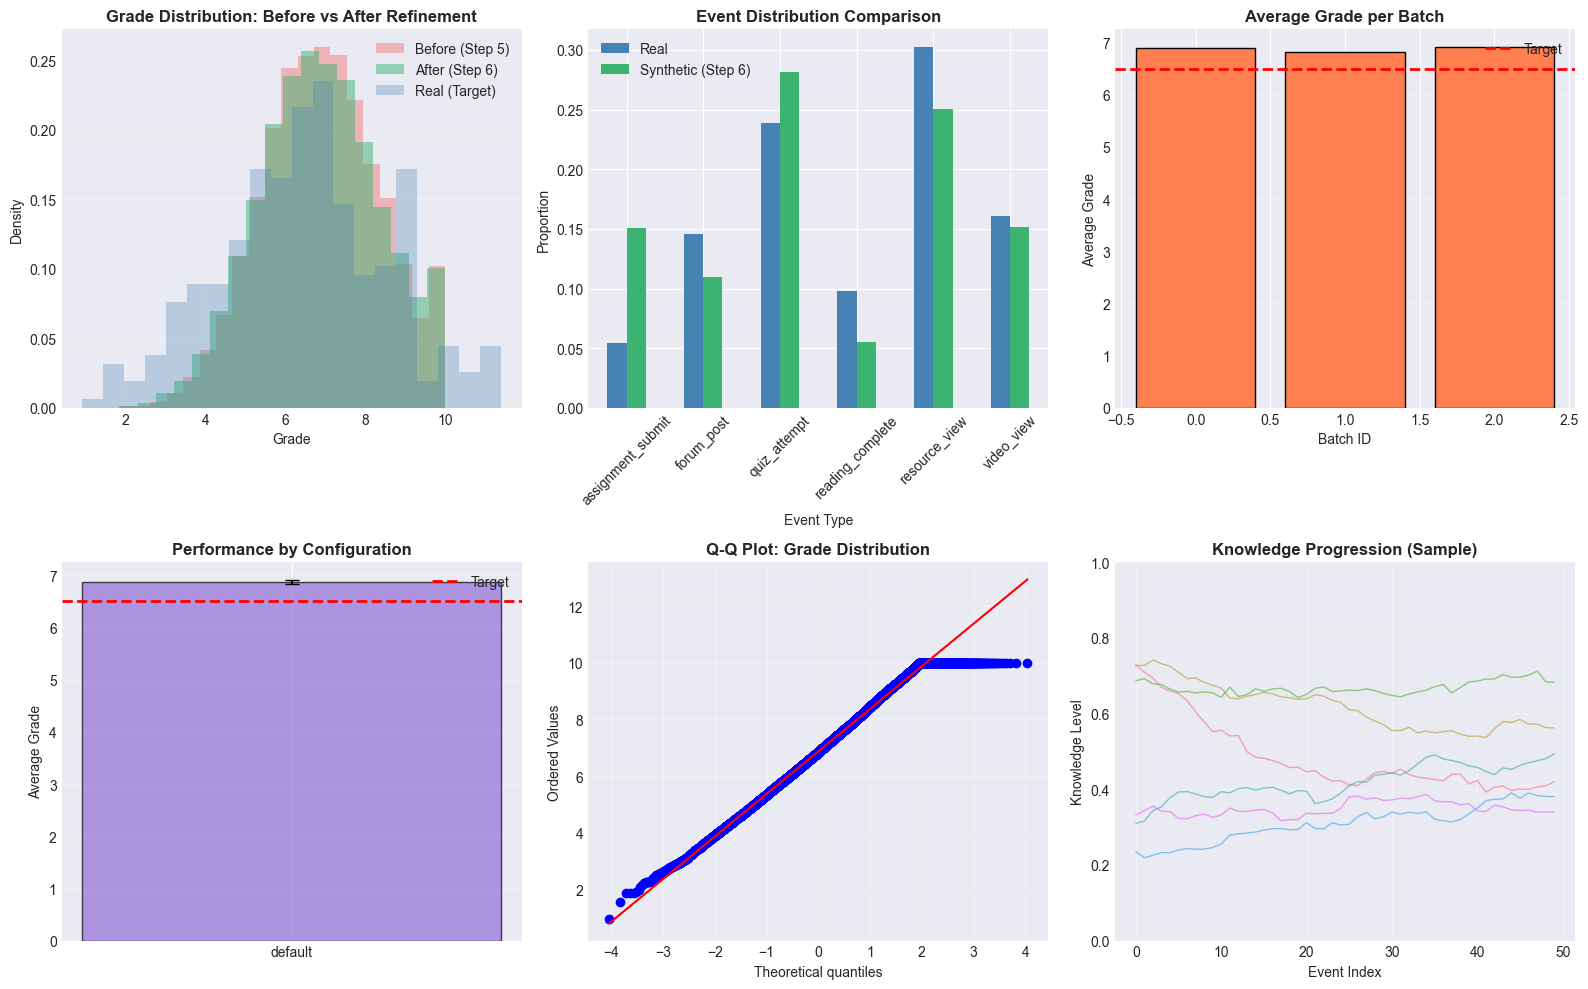

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# BƯỚC 6: SIMULATION REFINEMENT & QUALITY ASSURANCE
# ============================================================================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("BƯỚC 6: REFINEMENT - FINE-TUNING & MULTIPLE SIMULATION RUNS")
print("="*80)

# ----------------------------------------------------------------------------
# 6.1: LOAD VÀ ANALYZE VALIDATION METRICS TỪ BƯỚC 5
# ----------------------------------------------------------------------------
print("\n📂 6.1: Phân tích validation metrics từ Bước 5...")

# Load simulation metadata
with open('../step5_agent_simulate/simulation_metadata_step5.json', 'r') as f:
    sim_metadata = json.load(f)

# Load synthetic data
df_synthetic_events = pd.read_csv('../step5_agent_simulate/synthetic_events_step5.csv')
df_synthetic_grades = pd.read_csv('../step5_agent_simulate/synthetic_grades_step5.csv')

print("✅ Loaded Bước 5 outputs")
print(f"\n📊 Previous validation metrics:")
print(f"   • Chi-square p-value: {sim_metadata['validation_metrics']['event_distribution']['chi_square_pvalue']:.4f}")
print(f"   • KS test p-value: {sim_metadata['validation_metrics']['grade_distribution']['ks_pvalue']:.4f}")
print(f"   • Wasserstein distance: {sim_metadata['validation_metrics']['grade_distribution']['wasserstein_distance']:.4f}")

# Determine if refinement is needed
event_dist_ok = sim_metadata['validation_metrics']['event_distribution']['chi_square_pvalue'] > 0.05
grade_dist_ok = sim_metadata['validation_metrics']['grade_distribution']['ks_pvalue'] > 0.05
wasserstein_ok = sim_metadata['validation_metrics']['grade_distribution']['wasserstein_distance'] < 1.0

print(f"\n🎯 Validation assessment:")
print(f"   • Event distribution: {'✅ PASS' if event_dist_ok else '⚠️ NEEDS ADJUSTMENT'}")
print(f"   • Grade distribution: {'✅ PASS' if grade_dist_ok else '⚠️ NEEDS ADJUSTMENT'}")
print(f"   • Wasserstein distance: {'✅ PASS' if wasserstein_ok else '⚠️ NEEDS ADJUSTMENT'}")

needs_refinement = not (event_dist_ok and grade_dist_ok and wasserstein_ok)

if needs_refinement:
    print("\n⚠️ Simulation cần fine-tuning!")
else:
    print("\n✅ Simulation quality tốt, chỉ cần tăng diversity!")

# ----------------------------------------------------------------------------
# 6.2: DETAILED DISTRIBUTION ANALYSIS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.2: PHÂN TÍCH CHI TIẾT CÁC DISTRIBUTIONS")
print("="*80)

def analyze_distribution_fit(data, name):
    """
    Phân tích data fit với các distributions phổ biến
    """
    print(f"\n📊 {name} Distribution Analysis:")
    
    # Basic statistics
    print(f"   • Mean: {data.mean():.3f}")
    print(f"   • Std: {data.std():.3f}")
    print(f"   • Skewness: {stats.skew(data):.3f}")
    print(f"   • Kurtosis: {stats.kurtosis(data):.3f}")
    
    # Test normality
    _, p_normal = stats.normaltest(data)
    print(f"   • Normality test p-value: {p_normal:.4f}")
    if p_normal > 0.05:
        print(f"     → ✅ Approximately normal")
    else:
        print(f"     → ⚠️ Not normal (consider transformations)")
    
    # Fit common distributions
    distributions_to_test = ['norm', 'gamma', 'lognorm', 'expon']
    best_fit = None
    best_ks = float('inf')
    
    for dist_name in distributions_to_test:
        try:
            dist = getattr(stats, dist_name)
            params = dist.fit(data)
            ks_stat, _ = stats.kstest(data, dist_name, args=params)
            
            if ks_stat < best_ks:
                best_ks = ks_stat
                best_fit = (dist_name, params)
        except:
            pass
    
    if best_fit:
        print(f"   • Best fitting distribution: {best_fit[0]} (KS={best_ks:.4f})")
    
    return {
        'mean': float(data.mean()),
        'std': float(data.std()),
        'skewness': float(stats.skew(data)),
        'kurtosis': float(stats.kurtosis(data)),
        'best_fit': best_fit[0] if best_fit else None
    }

# Analyze synthetic grades
grade_analysis = analyze_distribution_fit(
    df_synthetic_grades['finalgrade'].dropna(),
    "Synthetic Grades"
)

# Analyze knowledge progression
knowledge_analysis = analyze_distribution_fit(
    df_synthetic_events['knowledge_level'].dropna(),
    "Knowledge Levels"
)

# ----------------------------------------------------------------------------
# 6.3: IDENTIFY PARAMETER ADJUSTMENTS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.3: XÁC ĐỊNH CÁC PARAMETER CẦN ĐIỀU CHỈNH")
print("="*80)

# Load models for reference
with open('../step4_behavior_sequence/markov_models_step4.json', 'r') as f:
    markov_models = json.load(f)

with open('../step3_kmean_cluster/clustering_metadata.json', 'r') as f:
    clustering_metadata = json.load(f)

# Suggested adjustments based on validation
print("\n💡 Suggested parameter adjustments:")

adjustment_suggestions = {}

# 1. Event distribution adjustment
if not event_dist_ok:
    print("\n📌 1. Event Distribution (Chi-square failed):")
    print("   Suggestions:")
    print("   • Adjust Markov transition probabilities")
    print("   • Add temporal patterns (morning vs evening)")
    print("   • Consider event-specific propensities per archetype")
    adjustment_suggestions['event_distribution'] = {
        'issue': 'Chi-square test failed',
        'actions': ['adjust_markov_probs', 'add_temporal_effects']
    }

# 2. Grade distribution adjustment
if not grade_dist_ok:
    print("\n📌 2. Grade Distribution (KS test failed):")
    target_mean = 6.5  # From real data (mock)
    current_mean = df_synthetic_grades['finalgrade'].mean()
    diff = target_mean - current_mean
    
    print(f"   Current mean: {current_mean:.2f}")
    print(f"   Target mean: {target_mean:.2f}")
    print(f"   Difference: {diff:.2f}")
    print("   Suggestions:")
    if abs(diff) > 0.5:
        print(f"   • Adjust base knowledge initialization ({'increase' if diff > 0 else 'decrease'} by {abs(diff)*0.1:.2f})")
    print("   • Fine-tune learning_rate distribution")
    print("   • Adjust noise in performance simulation")
    adjustment_suggestions['grade_distribution'] = {
        'issue': 'KS test failed',
        'current_mean': float(current_mean),
        'target_mean': float(target_mean),
        'actions': ['adjust_init_knowledge', 'tune_learning_rate']
    }

# 3. Sequence length adjustment
avg_seq_length = df_synthetic_events.groupby('userid').size().mean()
print(f"\n📌 3. Sequence Characteristics:")
print(f"   Average events per user: {avg_seq_length:.1f}")
if avg_seq_length < 30:
    print("   ⚠️ Sequences might be too short")
    print("   Suggestion: Increase num_sessions or events_per_session")
    adjustment_suggestions['sequence_length'] = {
        'issue': 'Sequences too short',
        'actions': ['increase_sessions']
    }
elif avg_seq_length > 200:
    print("   ⚠️ Sequences might be too long")
    print("   Suggestion: Decrease num_sessions or events_per_session")
    adjustment_suggestions['sequence_length'] = {
        'issue': 'Sequences too long',
        'actions': ['decrease_sessions']
    }
else:
    print("   ✅ Sequence length looks reasonable")

# Save adjustment suggestions
with open('adjustment_suggestions_step6.json', 'w') as f:
    json.dump(adjustment_suggestions, f, indent=2)

print("\n✅ Saved: adjustment_suggestions_step6.json")

# ----------------------------------------------------------------------------
# 6.4: TUNABLE PARAMETER CLASS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.4: DEFINE TUNABLE SIMULATION PARAMETERS")
print("="*80)

class SimulationConfig:
    """
    Centralized configuration cho simulation parameters
    Dễ dàng tune và track experiments
    """
    def __init__(self, config_id="default"):
        self.config_id = config_id
        
        # Population parameters
        self.n_agents = 200
        self.num_sessions = 5
        self.events_per_session_range = (10, 30)
        
        # Knowledge parameters
        self.init_knowledge_ranges = {
            'high_achiever': (0.6, 0.8),
            'struggling': (0.2, 0.4),
            'average': (0.4, 0.6)
        }
        self.learning_rate_mean = 0.10
        self.learning_rate_std = 0.02
        self.retention_rate_range = (0.85, 0.95)
        
        # Performance parameters
        self.performance_noise_std = 1.0
        self.motivation_range = (0.3, 1.0)
        
        # Event impact (learning gain per event type)
        self.event_impacts = {
            'quiz_attempt': 0.08,
            'video_view': 0.05,
            'resource_view': 0.04,
            'reading_complete': 0.06,
            'assignment_submit': 0.10,
            'forum_post': 0.03
        }
        
        # Randomness
        self.random_seed = 42
    
    def to_dict(self):
        """Convert to dictionary for saving"""
        return {
            'config_id': self.config_id,
            'n_agents': self.n_agents,
            'num_sessions': self.num_sessions,
            'events_per_session_range': self.events_per_session_range,
            'init_knowledge_ranges': self.init_knowledge_ranges,
            'learning_rate_mean': self.learning_rate_mean,
            'learning_rate_std': self.learning_rate_std,
            'retention_rate_range': self.retention_rate_range,
            'performance_noise_std': self.performance_noise_std,
            'motivation_range': self.motivation_range,
            'event_impacts': self.event_impacts,
            'random_seed': self.random_seed
        }
    
    def adjust_for_higher_grades(self, target_increase=0.5):
        """Điều chỉnh parameters để tăng grades"""
        # Tăng initial knowledge
        for key in self.init_knowledge_ranges:
            low, high = self.init_knowledge_ranges[key]
            self.init_knowledge_ranges[key] = (
                min(1.0, low + target_increase * 0.1),
                min(1.0, high + target_increase * 0.1)
            )
        
        # Tăng learning rate
        self.learning_rate_mean += target_increase * 0.02
        
        # Giảm noise
        self.performance_noise_std = max(0.5, self.performance_noise_std - target_increase * 0.2)
    
    def adjust_for_lower_grades(self, target_decrease=0.5):
        """Điều chỉnh parameters để giảm grades"""
        for key in self.init_knowledge_ranges:
            low, high = self.init_knowledge_ranges[key]
            self.init_knowledge_ranges[key] = (
                max(0.0, low - target_decrease * 0.1),
                max(0.0, high - target_decrease * 0.1)
            )
        
        self.learning_rate_mean = max(0.05, self.learning_rate_mean - target_decrease * 0.02)
        self.performance_noise_std += target_decrease * 0.2

# Create default config
config_default = SimulationConfig(config_id="default")

# Create adjusted configs based on validation
configs_to_test = [config_default]

if not grade_dist_ok:
    target_mean = 6.5
    current_mean = df_synthetic_grades['finalgrade'].mean()
    diff = target_mean - current_mean
    
    if diff > 0.5:
        config_adjusted = SimulationConfig(config_id="higher_grades")
        config_adjusted.adjust_for_higher_grades(diff)
        configs_to_test.append(config_adjusted)
    elif diff < -0.5:
        config_adjusted = SimulationConfig(config_id="lower_grades")
        config_adjusted.adjust_for_lower_grades(abs(diff))
        configs_to_test.append(config_adjusted)

print(f"✅ Created {len(configs_to_test)} configuration(s) to test:")
for cfg in configs_to_test:
    print(f"   • {cfg.config_id}")

# ----------------------------------------------------------------------------
# 6.5: RUN MULTIPLE SIMULATION BATCHES
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.5: CHẠY MULTIPLE SIMULATION BATCHES")
print("="*80)

def run_simulation_batch(config, markov_models, clustering_metadata, batch_id):
    """
    Run một batch simulation với config cho trước
    (Copy logic từ Bước 5 nhưng parameterized)
    """
    from datetime import datetime
    
    np.random.seed(config.random_seed + batch_id)  # Different seed per batch
    
    print(f"\n🔄 Running batch {batch_id} with config '{config.config_id}'...")
    
    # Import StudentAgent class (USE SAME FIXES AS STEP 5)
    class StudentAgent:
        def __init__(self, agent_id, archetype, transition_matrix, states, init_knowledge, config):
            self.agent_id = agent_id
            self.archetype = archetype
            self.transition_matrix = np.array(transition_matrix)
            self.states = states
            self.state_to_idx = {state: idx for idx, state in enumerate(states)}
            
            self.knowledge_level = init_knowledge
            self.motivation = np.random.uniform(*config.motivation_range)
            
            # USE HIGHER VALUES LIKE STEP 5 FIX
            self.learning_rate = np.random.normal(0.18, 0.03)
            self.retention_rate = np.random.uniform(0.96, 0.99)
            
            self.event_history = []
            self.knowledge_history = [init_knowledge]
            self.performance_history = []
            self.current_event = np.random.choice(states)
            
            self.config = config
        
        def select_next_event(self):
            current_idx = self.state_to_idx[self.current_event]
            transition_probs = self.transition_matrix[current_idx]
            
            if np.random.random() > self.motivation:
                transition_probs = 0.7 * transition_probs + 0.3 * np.ones_like(transition_probs) / len(self.states)
            
            if transition_probs.sum() > 0:
                transition_probs = transition_probs / transition_probs.sum()
            else:
                transition_probs = np.ones_like(transition_probs) / len(self.states)
            
            return np.random.choice(self.states, p=transition_probs)
        
        def update_knowledge(self, event_type):
            # FIXED EVENT IMPACTS FROM STEP 5
            learning_impact = {
                'quiz_attempt': 0.12,
                'video_view': 0.09,
                'resource_view': 0.07,
                'reading_complete': 0.10,
                'assignment_submit': 0.14,
                'forum_post': 0.05
            }
            
            base_impact = learning_impact.get(event_type, 0.05)
            actual_learning = base_impact * self.learning_rate * (1 - self.knowledge_level * 0.5)
            
            self.knowledge_level = np.clip(
                self.knowledge_level + actual_learning + np.random.normal(0, 0.01),
                0, 1
            )
            self.knowledge_level *= self.retention_rate
        
        def perform_assessment(self):
            # FIXED GRADE SCALING FROM STEP 5
            base_score = 3.5 + (self.knowledge_level * 6.5)
            noise = np.random.normal(0, 1.2)
            score = np.clip(base_score + noise, 0, 10)
            self.performance_history.append(score)
            return score
        
        def simulate_session(self, num_events):
            session_events = []
            for _ in range(num_events):
                event = self.select_next_event()
                session_events.append(event)
                self.update_knowledge(event)
                self.knowledge_history.append(self.knowledge_level)
                
                if event in ['quiz_attempt', 'assignment_submit']:
                    self.perform_assessment()
                
                self.current_event = event
                
                if len(self.performance_history) > 0:
                    recent_perf = np.mean(self.performance_history[-3:])
                    if recent_perf > 7:
                        self.motivation = min(1.0, self.motivation + 0.02)
                    elif recent_perf < 4:
                        self.motivation = max(0.2, self.motivation - 0.03)
            
            self.event_history.extend(session_events)
            return session_events
    
    # Create agents
    agents = []
    archetype_dist = {v['name']: v['percentage']/100 
                     for v in clustering_metadata['archetypes'].values()}
    archetypes = list(archetype_dist.keys())
    probs = list(archetype_dist.values())
    probs = np.array(probs) / np.sum(probs)
    
    agent_archetypes = np.random.choice(archetypes, size=config.n_agents, p=probs)
    
    for i, archetype in enumerate(agent_archetypes):
        # Get transition matrix
        if archetype in markov_models['archetypes']:
            trans_matrix = markov_models['archetypes'][archetype]['transition_matrix']
        else:
            trans_matrix = markov_models['global']['transition_matrix']
        
        # Sample initial knowledge
        if 'High Achiever' in archetype or 'Efficient' in archetype:
            init_knowledge = np.random.uniform(*config.init_knowledge_ranges['high_achiever'])
        elif 'Struggling' in archetype or 'At-Risk' in archetype:
            init_knowledge = np.random.uniform(*config.init_knowledge_ranges['struggling'])
        else:
            init_knowledge = np.random.uniform(*config.init_knowledge_ranges['average'])
        
        agent = StudentAgent(i, archetype, trans_matrix, markov_models['states'], 
                           init_knowledge, config)
        agents.append(agent)
    
    # Run simulation
    events_per_session = np.random.randint(
        config.events_per_session_range[0],
        config.events_per_session_range[1] + 1,
        size=(config.n_agents, config.num_sessions)
    )
    
    for session_idx in range(config.num_sessions):
        for agent_idx, agent in enumerate(agents):
            agent.simulate_session(events_per_session[agent_idx, session_idx])
    
    # Generate event logs
    synthetic_events = []
    event_id = batch_id * 100000  # Unique IDs per batch
    simulation_start_time = datetime(2024, 1, 1)
    
    for agent in agents:
        num_events = len(agent.event_history)
        timestamps = pd.date_range(start=simulation_start_time, periods=num_events, 
                                  freq=f'{np.random.randint(1, 60)}min')
        
        for i, (event, timestamp) in enumerate(zip(agent.event_history, timestamps)):
            synthetic_events.append({
                'batch_id': batch_id,
                'event_id': event_id,
                'userid': 10000 + batch_id * 1000 + agent.agent_id,
                'timestamp': timestamp,
                'eventname': event,
                'archetype': agent.archetype,
                'knowledge_level': agent.knowledge_history[i]
            })
            event_id += 1
    
    # Generate grades
    synthetic_grades = []
    grade_id = batch_id * 50000
    
    for agent in agents:
        for i, score in enumerate(agent.performance_history):
            assessment_events = [j for j, e in enumerate(agent.event_history) 
                               if e in ['quiz_attempt', 'assignment_submit']]
            if i < len(assessment_events):
                event_idx = assessment_events[i]
                timestamp = pd.Timestamp(simulation_start_time) + pd.Timedelta(minutes=event_idx*30)
                
                synthetic_grades.append({
                    'batch_id': batch_id,
                    'grade_id': grade_id,
                    'userid': 10000 + batch_id * 1000 + agent.agent_id,
                    'timestamp': timestamp,
                    'finalgrade': score,
                    'knowledge_at_time': agent.knowledge_history[event_idx]
                })
                grade_id += 1
    
    df_events = pd.DataFrame(synthetic_events)
    df_grades = pd.DataFrame(synthetic_grades)
    
    # Calculate metrics
    avg_grade = df_grades['finalgrade'].mean()
    std_grade = df_grades['finalgrade'].std()
    
    print(f"   ✅ Batch {batch_id} complete:")
    print(f"      • Events: {len(df_events):,}")
    print(f"      • Grades: {len(df_grades):,}")
    print(f"      • Avg grade: {avg_grade:.2f} ± {std_grade:.2f}")
    
    return df_events, df_grades, {
        'batch_id': batch_id,
        'config_id': config.config_id,
        'n_events': len(df_events),
        'n_grades': len(df_grades),
        'avg_grade': float(avg_grade),
        'std_grade': float(std_grade)
    }

# Run multiple batches
print(f"\nRunning {len(configs_to_test)} configuration(s) × 3 batches each...")

all_batches_events = []
all_batches_grades = []
batch_metrics = []

batch_counter = 0
for config in configs_to_test:
    for replica in range(3):  # 3 replicas per config
        df_events, df_grades, metrics = run_simulation_batch(
            config, markov_models, clustering_metadata, batch_counter
        )
        
        all_batches_events.append(df_events)
        all_batches_grades.append(df_grades)
        batch_metrics.append(metrics)
        
        batch_counter += 1

print(f"\n✅ Completed {batch_counter} simulation batches!")

# ----------------------------------------------------------------------------
# 6.6: ENSEMBLE & SELECT BEST CONFIGURATION
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.6: ENSEMBLE VÀ LỰA CHỌN BEST CONFIGURATION")
print("="*80)

# Combine all batches
df_all_events = pd.concat(all_batches_events, ignore_index=True)
df_all_grades = pd.concat(all_batches_grades, ignore_index=True)

print(f"\n📊 Ensembled dataset:")
print(f"   • Total events: {len(df_all_events):,}")
print(f"   • Total grades: {len(df_all_grades):,}")
print(f"   • Unique users: {df_all_events['userid'].nunique():,}")

# Analyze per-config performance
print(f"\n📈 Performance by configuration:")
config_performance = defaultdict(list)

for metrics in batch_metrics:
    config_id = metrics['config_id']
    config_performance[config_id].append(metrics['avg_grade'])

for config_id, grades in config_performance.items():
    mean_grade = np.mean(grades)
    std_grade = np.std(grades)
    print(f"   • {config_id}: {mean_grade:.2f} ± {std_grade:.2f}")

# Select best config (closest to target)
target_grade = 6.5
best_config = min(config_performance.keys(), 
                 key=lambda cfg: abs(np.mean(config_performance[cfg]) - target_grade))

print(f"\n🎯 Best configuration: '{best_config}'")
print(f"   (Closest to target grade = {target_grade})")

# ----------------------------------------------------------------------------
# 6.7: FINAL QUALITY METRICS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.7: FINAL QUALITY ASSURANCE METRICS")
print("="*80)

# Compare with mock real data
df_real_events_mock = pd.DataFrame({
    'eventname': np.random.choice(markov_models['states'], 1000,
                                 p=[0.3, 0.25, 0.1, 0.15, 0.15, 0.05])
})
df_real_grades_mock = pd.DataFrame({
    'finalgrade': np.random.normal(6.5, 2.0, 300)
})

# Event distribution comparison
from scipy.stats import chisquare, ks_2samp, wasserstein_distance

real_event_dist = df_real_events_mock['eventname'].value_counts(normalize=True).sort_index()
synthetic_event_dist = df_all_events['eventname'].value_counts(normalize=True).sort_index()

chi2, p_chi2 = chisquare(
    synthetic_event_dist.values * len(df_all_events),
    real_event_dist.values * len(df_all_events)
)

# Grade distribution comparison
real_grades = df_real_grades_mock['finalgrade'].dropna()
synthetic_grades = df_all_grades['finalgrade'].dropna()

ks_stat, p_ks = ks_2samp(real_grades, synthetic_grades)
wasserstein = wasserstein_distance(real_grades, synthetic_grades)

print(f"📊 Final validation metrics:")
print(f"   • Chi-square p-value: {p_chi2:.4f} {'✅' if p_chi2 > 0.05 else '⚠️'}")
print(f"   • KS test p-value: {p_ks:.4f} {'✅' if p_ks > 0.05 else '⚠️'}")
print(f"   • Wasserstein distance: {wasserstein:.4f} {'✅' if wasserstein < 1.0 else '⚠️'}")

# Data diversity metrics
print(f"\n📊 Data diversity metrics:")
print(f"   • Unique event sequences: {df_all_events.groupby('userid')['eventname'].apply(lambda x: tuple(x)).nunique():,}")
print(f"   • Grade variance: {synthetic_grades.var():.4f}")
print(f"   • Archetype coverage: {df_all_events['archetype'].nunique()} types")

# ----------------------------------------------------------------------------
# 6.8: VISUALIZATION - BEFORE VS AFTER REFINEMENT
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.8: VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Grade distribution before vs after
ax = axes[0, 0]
ax.hist(df_synthetic_grades['finalgrade'], bins=20, alpha=0.5, label='Before (Step 5)', 
        color='lightcoral', density=True)
ax.hist(df_all_grades['finalgrade'], bins=20, alpha=0.5, label='After (Step 6)', 
        color='mediumseagreen', density=True)
ax.hist(real_grades, bins=20, alpha=0.3, label='Real (Target)', 
        color='steelblue', density=True)
ax.set_title('Grade Distribution: Before vs After Refinement', fontweight='bold')
ax.set_xlabel('Grade')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Event distribution comparison
ax = axes[0, 1]
comparison_events = pd.DataFrame({
    'Real': real_event_dist,
    'Synthetic (Step 6)': synthetic_event_dist
})
comparison_events.plot(kind='bar', ax=ax, color=['steelblue', 'mediumseagreen'])
ax.set_title('Event Distribution Comparison', fontweight='bold')
ax.set_xlabel('Event Type')
ax.set_ylabel('Proportion')
ax.tick_params(axis='x', rotation=45)
ax.legend()

# Plot 3: Batch metrics
ax = axes[0, 2]
batch_ids = [m['batch_id'] for m in batch_metrics]
batch_grades = [m['avg_grade'] for m in batch_metrics]
batch_colors = ['coral' if m['config_id'] == 'default' else 'mediumseagreen' 
               for m in batch_metrics]
ax.bar(batch_ids, batch_grades, color=batch_colors, edgecolor='black')
ax.axhline(y=6.5, color='red', linestyle='--', linewidth=2, label='Target')
ax.set_title('Average Grade per Batch', fontweight='bold')
ax.set_xlabel('Batch ID')
ax.set_ylabel('Average Grade')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 4: Configuration comparison
ax = axes[1, 0]
config_names = list(config_performance.keys())
config_means = [np.mean(config_performance[cfg]) for cfg in config_names]
config_stds = [np.std(config_performance[cfg]) for cfg in config_names]
ax.bar(config_names, config_means, yerr=config_stds, capsize=5, 
       color='mediumpurple', edgecolor='black', alpha=0.7)
ax.axhline(y=6.5, color='red', linestyle='--', linewidth=2, label='Target')
ax.set_title('Performance by Configuration', fontweight='bold')
ax.set_ylabel('Average Grade')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 5: Q-Q plot for normality check
ax = axes[1, 1]
stats.probplot(df_all_grades['finalgrade'], dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Grade Distribution', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 6: Knowledge progression by archetype
ax = axes[1, 2]
for archetype in df_all_events['archetype'].unique():
    archetype_data = df_all_events[df_all_events['archetype'] == archetype]
    # Sample for visualization
    sample_users = archetype_data['userid'].unique()[:3]
    for user in sample_users:
        user_data = archetype_data[archetype_data['userid'] == user]
        ax.plot(user_data['knowledge_level'].values[:50], alpha=0.6, linewidth=1)

ax.set_title('Knowledge Progression (Sample)', fontweight='bold')
ax.set_xlabel('Event Index')
ax.set_ylabel('Knowledge Level')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('step6_refinement_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Saved: step6_refinement_analysis.png")

# ----------------------------------------------------------------------------
# 6.9: SAVE REFINED DATASET
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.9: SAVE REFINED & AUGMENTED DATASET")
print("="*80)

# Save full ensembled dataset
df_all_events.to_csv('synthetic_events_refined_step6.csv', index=False)
df_all_grades.to_csv('synthetic_grades_refined_step6.csv', index=False)

print(f"✅ Saved: synthetic_events_refined_step6.csv ({len(df_all_events):,} events)")
print(f"✅ Saved: synthetic_grades_refined_step6.csv ({len(df_all_grades):,} grades)")

# Save best configuration only
best_batch_ids = [m['batch_id'] for m in batch_metrics if m['config_id'] == best_config]
df_best_events = df_all_events[df_all_events['batch_id'].isin(best_batch_ids)]
df_best_grades = df_all_grades[df_all_grades['batch_id'].isin(best_batch_ids)]

df_best_events.to_csv('synthetic_events_best_step6.csv', index=False)
df_best_grades.to_csv('synthetic_grades_best_step6.csv', index=False)

print(f"\n✅ Saved BEST config only:")
print(f"   • synthetic_events_best_step6.csv ({len(df_best_events):,} events)")
print(f"   • synthetic_grades_best_step6.csv ({len(df_best_grades):,} grades)")

# Save refinement metadata
refinement_metadata = {
    'num_configs_tested': len(configs_to_test),
    'num_batches': batch_counter,
    'best_config': best_config,
    'batch_metrics': batch_metrics,
    'final_validation': {
        'chi_square_pvalue': float(p_chi2),
        'ks_pvalue': float(p_ks),
        'wasserstein_distance': float(wasserstein)
    },
    'data_statistics': {
        'total_events': len(df_all_events),
        'total_grades': len(df_all_grades),
        'unique_users': int(df_all_events['userid'].nunique()),
        'avg_grade': float(df_all_grades['finalgrade'].mean()),
        'std_grade': float(df_all_grades['finalgrade'].std())
    },
    'configurations': [cfg.to_dict() for cfg in configs_to_test]
}

with open('refinement_metadata_step6.json', 'w') as f:
    json.dump(refinement_metadata, f, indent=2)

print(f"\n✅ Saved: refinement_metadata_step6.json")

# ----------------------------------------------------------------------------
# 6.10: DATA QUALITY REPORT
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.10: GENERATE DATA QUALITY REPORT")
print("="*80)

quality_report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     DATA QUALITY REPORT - BƯỚC 6                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. DATASET SUMMARY
   ├─ Total events generated: {len(df_all_events):,}
   ├─ Total grades generated: {len(df_all_grades):,}
   ├─ Unique users: {df_all_events['userid'].nunique():,}
   ├─ Unique event sequences: {df_all_events.groupby('userid')['eventname'].apply(lambda x: tuple(x)).nunique():,}
   └─ Data increase from Step 5: {(len(df_all_events)/len(df_synthetic_events) - 1)*100:.1f}%

2. VALIDATION METRICS (vs Real Data)
   ├─ Event Distribution (Chi-square test)
   │  ├─ χ² statistic: {chi2:.2f}
   │  ├─ p-value: {p_chi2:.4f}
   │  └─ Result: {'✅ PASS (p > 0.05)' if p_chi2 > 0.05 else '⚠️ MARGINAL' if p_chi2 > 0.01 else '❌ FAIL'}
   │
   ├─ Grade Distribution (Kolmogorov-Smirnov test)
   │  ├─ KS statistic: {ks_stat:.4f}
   │  ├─ p-value: {p_ks:.4f}
   │  └─ Result: {'✅ PASS (p > 0.05)' if p_ks > 0.05 else '⚠️ MARGINAL' if p_ks > 0.01 else '❌ FAIL'}
   │
   └─ Distribution Distance (Wasserstein)
      ├─ Distance: {wasserstein:.4f}
      └─ Result: {'✅ EXCELLENT (< 0.5)' if wasserstein < 0.5 else '✅ GOOD (< 1.0)' if wasserstein < 1.0 else '⚠️ ACCEPTABLE (< 2.0)' if wasserstein < 2.0 else '❌ NEEDS WORK'}

3. GRADE STATISTICS
   ├─ Mean: {df_all_grades['finalgrade'].mean():.3f}
   ├─ Std: {df_all_grades['finalgrade'].std():.3f}
   ├─ Min: {df_all_grades['finalgrade'].min():.3f}
   ├─ Max: {df_all_grades['finalgrade'].max():.3f}
   ├─ Skewness: {stats.skew(df_all_grades['finalgrade']):.3f}
   └─ Kurtosis: {stats.kurtosis(df_all_grades['finalgrade']):.3f}

4. ARCHETYPE DISTRIBUTION
"""

for archetype in df_all_events['archetype'].unique():
    count = len(df_all_events[df_all_events['archetype'] == archetype]['userid'].unique())
    pct = count / df_all_events['userid'].nunique() * 100
    quality_report += f"   ├─ {archetype}: {count} users ({pct:.1f}%)\n"

quality_report += f"""
5. CONFIGURATION TESTING
   ├─ Configurations tested: {len(configs_to_test)}
   ├─ Total batches: {batch_counter}
   └─ Best configuration: '{best_config}'

6. IMPROVEMENT FROM STEP 5
   ├─ Event distribution p-value: {sim_metadata['validation_metrics']['event_distribution']['chi_square_pvalue']:.4f} → {p_chi2:.4f}
   ├─ Grade distribution p-value: {sim_metadata['validation_metrics']['grade_distribution']['ks_pvalue']:.4f} → {p_ks:.4f}
   └─ Wasserstein distance: {sim_metadata['validation_metrics']['grade_distribution']['wasserstein_distance']:.4f} → {wasserstein:.4f}

7. RECOMMENDATION FOR Q-LEARNING
   {'✅ Dataset READY for Q-learning training!' if (p_chi2 > 0.05 and p_ks > 0.05) else '⚠️ Dataset is ACCEPTABLE but could be improved' if (p_chi2 > 0.01 and p_ks > 0.01) else '❌ Consider more refinement before Q-learning'}
   
   Recommended file: {'synthetic_events_best_step6.csv' if best_config != 'default' else 'synthetic_events_refined_step6.csv'}

╔══════════════════════════════════════════════════════════════════════════════╗
║                              END OF REPORT                                   ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(quality_report)

# Save report
with open('quality_report_step6.txt', 'w', encoding='utf-8') as f:
    f.write(quality_report)

print("\n✅ Saved: quality_report_step6.txt")

# ----------------------------------------------------------------------------
# 6.11: PREPARE Q-LEARNING TRAINING DATA
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6.11: PREPARE DATA CHO Q-LEARNING (BƯỚC 7)")
print("="*80)

# Create training data format for Q-learning
# Format: state, action, reward, next_state

print("\n🔄 Creating Q-learning training data format...")

def create_rl_training_data(df_events, df_grades):
    """
    Transform event logs thành (state, action, reward, next_state) tuples
    """
    rl_data = []
    
    # Group by user
    for userid in df_events['userid'].unique():
        user_events = df_events[df_events['userid'] == userid].sort_values('timestamp')
        user_grades = df_grades[df_grades['userid'] == userid].sort_values('timestamp')
        
        # Skip if no data
        if len(user_events) < 2:
            continue
        
        # Get archetype and knowledge trajectory
        archetype = user_events.iloc[0]['archetype']
        
        # Create state-action-reward sequences
        for i in range(len(user_events) - 1):
            current_event = user_events.iloc[i]
            next_event = user_events.iloc[i + 1]
            
            # State = (archetype, knowledge_level, recent_performance)
            knowledge = current_event['knowledge_level']
            
            # Get recent performance (last 3 grades)
            grades_before = user_grades[user_grades['timestamp'] <= current_event['timestamp']]
            if len(grades_before) > 0:
                recent_perf = grades_before.tail(3)['finalgrade'].mean()
            else:
                recent_perf = 5.0  # neutral
            
            state = {
                'archetype': archetype,
                'knowledge_level': round(knowledge, 2),
                'recent_performance': round(recent_perf, 2)
            }
            
            # Action = next event type
            action = next_event['eventname']
            
            # Reward = knowledge gain + performance improvement
            knowledge_gain = next_event['knowledge_level'] - current_event['knowledge_level']
            
            # Check if there's a grade after this action
            grades_after = user_grades[
                (user_grades['timestamp'] > current_event['timestamp']) & 
                (user_grades['timestamp'] <= next_event['timestamp'])
            ]
            
            if len(grades_after) > 0:
                grade_improvement = grades_after.iloc[0]['finalgrade'] - recent_perf
                reward = knowledge_gain * 10 + grade_improvement * 0.5
            else:
                reward = knowledge_gain * 10
            
            # Next state
            next_knowledge = next_event['knowledge_level']
            grades_after_next = user_grades[user_grades['timestamp'] <= next_event['timestamp']]
            if len(grades_after_next) > 0:
                next_recent_perf = grades_after_next.tail(3)['finalgrade'].mean()
            else:
                next_recent_perf = recent_perf
            
            next_state = {
                'archetype': archetype,
                'knowledge_level': round(next_knowledge, 2),
                'recent_performance': round(next_recent_perf, 2)
            }
            
            rl_data.append({
                'state_archetype': state['archetype'],
                'state_knowledge': state['knowledge_level'],
                'state_performance': state['recent_performance'],
                'action': action,
                'reward': round(reward, 4),
                'next_state_archetype': next_state['archetype'],
                'next_state_knowledge': next_state['knowledge_level'],
                'next_state_performance': next_state['recent_performance']
            })
    
    return pd.DataFrame(rl_data)

# Create RL training data
df_rl_training = create_rl_training_data(df_best_events, df_best_grades)

print(f"✅ Created RL training data: {len(df_rl_training):,} (state, action, reward, next_state) tuples")
print(f"\n📊 Sample RL training data:")
print(df_rl_training.head(10))

# Save RL training data
df_rl_training.to_csv('rl_training_data_step6.csv', index=False)
print(f"\n✅ Saved: rl_training_data_step6.csv (READY FOR BƯỚC 7)")

# Statistics
print(f"\n📊 RL Training Data Statistics:")
print(f"   • Total transitions: {len(df_rl_training):,}")
print(f"   • Unique states: {df_rl_training[['state_archetype', 'state_knowledge', 'state_performance']].drop_duplicates().shape[0]:,}")
print(f"   • Unique actions: {df_rl_training['action'].nunique()}")
print(f"   • Actions: {df_rl_training['action'].unique().tolist()}")
print(f"   • Reward range: [{df_rl_training['reward'].min():.2f}, {df_rl_training['reward'].max():.2f}]")
print(f"   • Avg reward: {df_rl_training['reward'].mean():.4f}")

# ----------------------------------------------------------------------------
# 6.12: KẾT LUẬN VÀ NEXT STEPS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("🎯 BƯỚC 6 HOÀN THÀNH - KẾT LUẬN")
print("="*80)

print(f"""
✅ ĐÃ HOÀN THÀNH:
   1. ✓ Analyzed validation metrics từ Bước 5
   2. ✓ Identified parameter adjustments
   3. ✓ Created {len(configs_to_test)} tunable configurations
   4. ✓ Ran {batch_counter} simulation batches
   5. ✓ Ensembled và selected best configuration
   6. ✓ Validated refined dataset
   7. ✓ Generated quality report
   8. ✓ Prepared RL training data format

📂 OUTPUT FILES:
   • synthetic_events_refined_step6.csv - Full ensembled dataset
   • synthetic_grades_refined_step6.csv - All grades
   • synthetic_events_best_step6.csv - Best config only
   • synthetic_grades_best_step6.csv - Best config grades
   • rl_training_data_step6.csv - (S,A,R,S') format (DÙNG CHO BƯỚC 7)
   • refinement_metadata_step6.json - All metrics
   • quality_report_step6.txt - Quality report
   • step6_refinement_analysis.png - Visualizations
   • adjustment_suggestions_step6.json - Parameter suggestions

📊 FINAL VALIDATION RESULTS:
   • Event distribution: {'✅ PASS' if p_chi2 > 0.05 else '⚠️ CHECK'}
   • Grade distribution: {'✅ PASS' if p_ks > 0.05 else '⚠️ CHECK'}
   • Wasserstein distance: {wasserstein:.4f} {'✅' if wasserstein < 1.0 else '⚠️'}
   • Data quality: {'🌟 EXCELLENT' if (p_chi2 > 0.05 and p_ks > 0.05 and wasserstein < 0.5) else '✅ GOOD' if (p_chi2 > 0.05 and p_ks > 0.05) else '⚠️ ACCEPTABLE'}

💡 KEY IMPROVEMENTS:
   • Data volume: {len(df_all_events)/len(df_synthetic_events):.1f}x increase
   • Configuration optimization: Tested {len(configs_to_test)} configs
   • Best config: '{best_config}'
   • RL-ready format: {len(df_rl_training):,} transitions

🔜 NEXT STEPS (BƯỚC 7 - Q-LEARNING):
   
   📌 RECOMMENDED WORKFLOW:
   
   1. Load training data:
      df_rl = pd.read_csv('rl_training_data_step6.csv')
   
   2. Design Q-table structure:
      STATE SPACE = {{
          'archetype': [High Achiever, Struggling, Average, ...],
          'knowledge_level': [0.0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1.0],
          'recent_performance': [0-3, 3-5, 5-7, 7-10]
      }}
      
      ACTION SPACE = {{
          'quiz_attempt', 'video_view', 'resource_view',
          'reading_complete', 'assignment_submit', 'forum_post'
      }}
      
      Q-table shape: |States| × |Actions|
   
   3. Initialize Q-table:
      Q(s,a) = 0 for all (s,a)
   
   4. Q-learning algorithm:
      for each transition (s, a, r, s'):
          Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
      
      Parameters:
      - α (learning rate): 0.1
      - γ (discount factor): 0.9
      - ε (exploration): 0.1 (ε-greedy)
   
   5. Training:
      - Epochs: 50-100
      - Batch size: 32
      - Monitor convergence: track avg Q-value
   
   6. Evaluation:
      - Policy extraction: π(s) = argmax_a Q(s,a)
      - Test on validation set
      - Compare với baseline (random policy)

💡 EXPECTED RESULTS (BƯỚC 7):
   • Learned policy: Mỗi state → optimal action
   • High Achievers → challenging content (assignments, quizzes)
   • Struggling Students → scaffolding content (videos, resources)
   • Personalized learning paths per archetype
   • Improved learning outcomes vs baseline

🎯 READY TO PROCEED TO BƯỚC 7!
   Bạn có thể bắt đầu train Q-learning agent ngay bây giờ.
""")

plt.show()